<a href="https://colab.research.google.com/github/tawanamutasa/Weather-wise-Tawana-mutasa-/blob/main/Weatherwise_Tawana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Weather Wise App **

In [22]:
import requests
import pyinputplus as pyip
import matplotlib.pyplot as plt
from datetime import datetime
from geopy.geocoders import Nominatim
import ipywidgets as widgets
from IPython.display import display, clear_output



In [6]:
def get_coordinates(city_name):
    geolocator = Nominatim(user_agent="weather_app")
    location = geolocator.geocode(city_name)
    if location:
        return location.latitude, location.longitude
    else:
        raise ValueError("Location not found.")

In [11]:
def get_weather_forecast(lat, lon):
    url = (
        f"https://api.open-meteo.com/v1/forecast?"
        f"latitude={lat}&longitude={lon}"
        f"&hourly=temperature_2m,precipitation_probability"
        f"&timezone=auto"
    )
    response = requests.get(url)
    return response.json()

In [12]:
def get_weather_data(city_name, forecast_days=5):
    """
    Retrieve weather data for a specified location.

    Args:
        location (str): City or location name
        forecast_days (int): Number of days to forecast (1-5)

    Returns:
        dict: Weather data including hourly forecast for temperature and precipitation
    """
    if not (1 <= forecast_days <= 5):
        raise ValueError("forecast_days must be between 1 and 5")

    # Get coordinates
    lat, lon = get_coordinates(city_name)

    # Build Open-Meteo API URL
    url = (
        f"https://api.open-meteo.com/v1/forecast?"
        f"latitude={lat}&longitude={lon}"
        f"&hourly=temperature_2m,precipitation_probability"
        f"&forecast_days={forecast_days}"
        f"&timezone=auto"
    )

    # Fetch data
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to retrieve data: {response.status_code}")

    return response.json()

In [13]:
def create_temperature_visualisation(weather_data, output_type='display', city=None):
    """
    Create visualisation of temperature data.

    Args:
        weather_data (dict): The processed weather data (output of get_weather_forecast)
        output_type (str): 'display' to show plot, 'figure' to return the figure
        city (str): Optional city name for the plot title

    Returns:
        matplotlib.figure.Figure or None
    """
    # Extract time and temperature data
    times_str = weather_data['hourly']['time']
    temps = weather_data['hourly']['temperature_2m']

    # Convert time strings to datetime objects for better x-axis formatting
    time_objects = [datetime.fromisoformat(t) for t in times_str]

    # Create figure and plot
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(time_objects, temps, label="Temperature (°C)", color='tab:red')
    ax.set_xlabel("Date & Time")
    ax.set_ylabel("Temperature (°C)")

    title = f"Hourly Temperature Forecast"
    if city:
        title += f" for {city}"
    ax.set_title(title)

    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    ax.legend()

    if output_type == 'figure':
        return fig
    else:
        plt.show()
        return None

In [14]:
def create_precipitation_visualisation(weather_data, output_type='display', city=None):
    """
    Create visualisation of precipitation data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure
        city (str): Optional city name for the plot title

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """
    # Extract time and precipitation probability data
    times_str = weather_data['hourly']['time']
    rain_probs = weather_data['hourly']['precipitation_probability']

    # Convert time strings to datetime objects
    time_objects = [datetime.fromisoformat(t) for t in times_str]

    # Create figure and plot
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(time_objects, rain_probs, label="Rain Chance (%)", color='tab:blue')
    ax.set_xlabel("Date & Time")
    ax.set_ylabel("Precipitation Probability (%)")

    # Set title
    title = "Hourly Rain Forecast"
    if city:
        title += f" for {city}"
    ax.set_title(title)

    # Final plot formatting
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    ax.legend()

    # Output
    if output_type == 'figure':
        return fig
    else:
        plt.show()
        return None

Enter a city: Australia
Coordinates for Australia: -24.78, 134.75


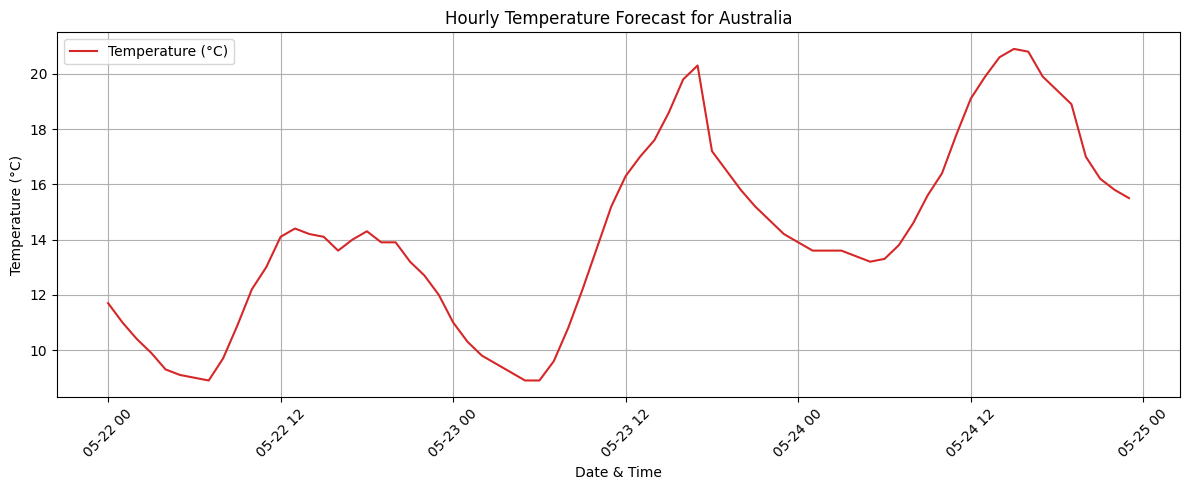

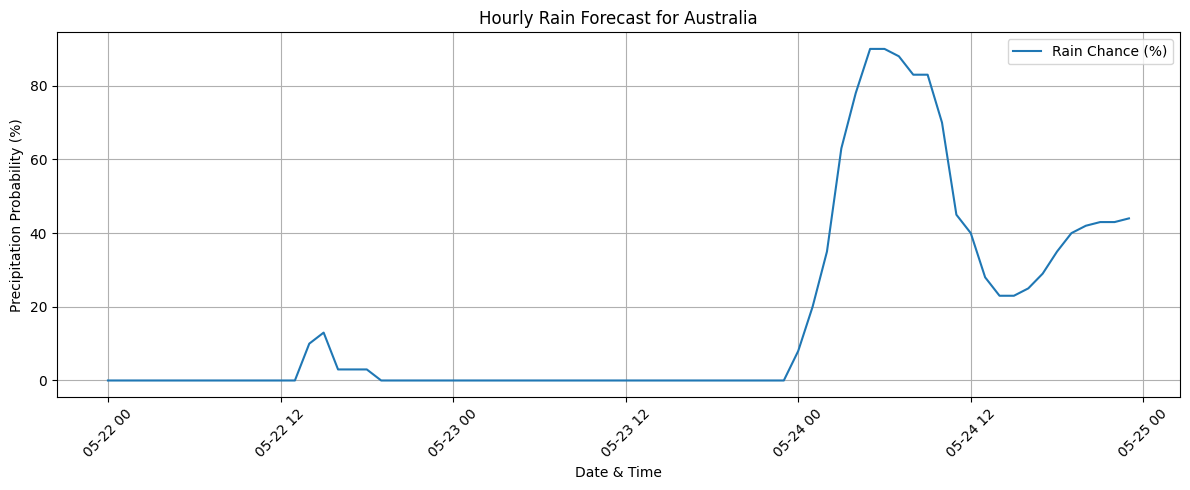

In [15]:
city = input("Enter a city: ")

try:
    lat, lon = get_coordinates(city)  # existing function to get lat/lon
    weather_data = get_weather_forecast(lat, lon)
    print(f"Coordinates for {city}: {lat:.2f}, {lon:.2f}")

    # Display returned data
    weather_data = get_weather_data("London", forecast_days=3)
    create_temperature_visualisation(weather_data, output_type='display', city=city)
    create_precipitation_visualisation(weather_data, output_type='display', city=city)

except ValueError as e:
    print(str(e))

📍 Forecast for: Perth



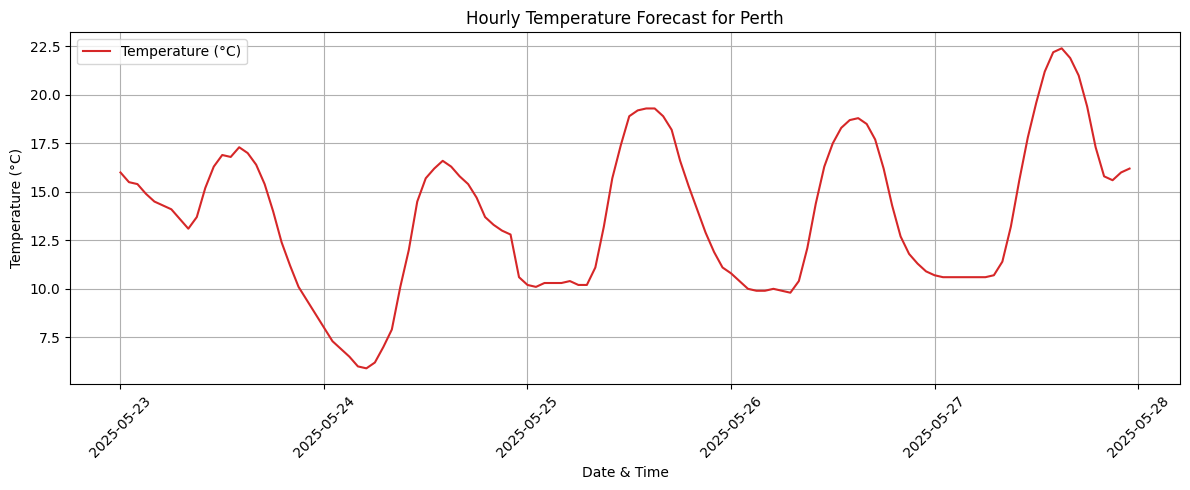

In [23]:
def widget_ui():
    # Input widgets
    city_input = widgets.Text(description='City:', placeholder='e.g. London')
    submit_button = widgets.Button(description='Get Forecast', button_style='info')
    output = widgets.Output()

    # Handle submit button click
    def on_submit(b):
        with output:
            clear_output()
            location = city_input.value.strip()

            if not location:
                print("⚠️ Please enter a valid city.")
                return

            try:
                weather_data = get_weather_data(location)

                print(f"📍 Forecast for: {location}")

                # Weather view menu
                menu = widgets.ToggleButtons(
                    options=['Current Weather', 'Temperature Forecast', 'Precipitation Forecast'],
                    description='View:',
                    button_style='primary'
                )

                def on_choice(change):
                    clear_output(wait=True)
                    print(f"📍 Forecast for: {location}\n")

                    if change['new'] == 'Current Weather':
                        current = weather_data['current_weather']
                        print(f"🌤 Current Weather")
                        print(f"Temperature: {current['temperature']}°C")
                        print(f"Windspeed: {current['windspeed']} km/h")
                        print(f"Time: {current['time']}")

                    elif change['new'] == 'Temperature Forecast':
                        create_temperature_visualisation(weather_data, city=location)

                    elif change['new'] == 'Precipitation Forecast':
                        create_precipitation_visualisation(weather_data, city=location)

                menu.observe(on_choice, names='value')
                display(menu)

            except Exception as e:
                print("⚠️ Error getting weather data:", e)

    # Bind click event
    submit_button.on_click(on_submit)

    # Display input and output
    display(widgets.VBox([city_input, submit_button, output]))

#Activate the interface
widget_ui()



